# Beans Spot Classifier

Used for detecting wether a beans leaf is infected by any virus or not

[link](https://www.youtube.com/watch?v=84J1fMklQWE&ab_channel=AIEngineering)

## Importing modules

Don't forget to install first the dataset

In [2]:
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os 

import warnings
warnings.filterwarnings('ignore')

## Download dataset from the tf_dataset

In [3]:
dataset, info = tfds.load(name='beans', with_info=True, as_supervised=True, split=['train', 'test', 'validation'])

03:52,  1.83s/ MiB]
Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 31 examples [00:00, 310.00 examples/s]
Generating train examples...: 75 examples [00:00, 386.47 examples/s]
Generating train examples...: 126 examples [00:00, 440.77 examples/s]
Generating train examples...: 177 examples [00:00, 467.91 examples/s]
Generating train examples...: 227 examples [00:00, 477.92 examples/s]
Generating train examples...: 275 examples [00:00, 473.81 examples/s]
Generating train examples...: 323 examples [00:00, 448.22 examples/s]
Generating train examples...: 369 examples [00:00, 400.71 examples/s]
Generating train examples...: 421 examples [00:00, 432.64 examples/s]
Generating train examples...: 470 examples [00:01, 447.64 examples/s]
Generating train examples...: 516 examples [00:01, 446.06 examples/s]
Generating train examples...: 562 examples [00:01, 353.96 examples/s]
Generating tra

In [4]:
info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='C:\\Users\\asus\\tensorflow_datasets\\beans\\0.1.0',
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo n

## Make random examples from dataset

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


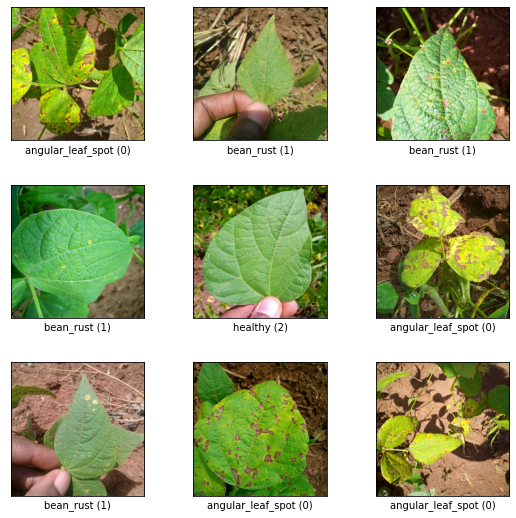

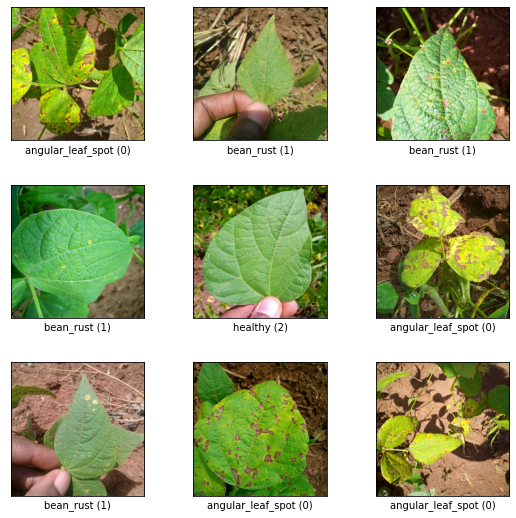

In [5]:
train, info_train = tfds.load(name='beans', with_info=True, split='test')
tfds.show_examples(info_train,train)

## Build function to make data processing more simpler

In [6]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255

    return tf.image.resize(image,[224,224]), tf.one_hot(label, 3)

In [8]:
def get_dataset(batch_size=32):
    train_data_scaled = dataset[0].map(scale).shuffle(1000).batch(batch_size)
    test_data_scaled = dataset[1].map(scale).batch(batch_size)
    val_data_scaled = dataset[2].map(scale).batch(batch_size)

    return train_data_scaled, test_data_scaled, val_data_scaled

In [9]:
train_data, test_data, val_data = get_dataset()
train_data.cache()
val_data.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [10]:
len(list(dataset[0]))

1034

## Prepare for training

We are using mobilenet_v2, so it need to be downloaded first

In [11]:
feature_extractor = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [12]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [13]:
feature_extractor_layer.trainable = False

In [14]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Training Process

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [16]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
33/33 [==============================] - 32s 786ms/step - loss: 0.9182 - acc: 0.5716 - val_loss: 0.5683 - val_acc: 0.7519
Epoch 2/10
33/33 [==============================] - 27s 779ms/step - loss: 0.5353 - acc: 0.7737 - val_loss: 0.4435 - val_acc: 0.8120
Epoch 3/10
33/33 [==============================] - 27s 768ms/step - loss: 0.4505 - acc: 0.8182 - val_loss: 0.3935 - val_acc: 0.8346
Epoch 4/10
33/33 [==============================] - 25s 726ms/step - loss: 0.3773 - acc: 0.8627 - val_loss: 0.3520 - val_acc: 0.8421
Epoch 5/10
33/33 [==============================] - 25s 714ms/step - loss: 0.3360 - acc: 0.8627 - val_loss: 0.3255 - val_acc: 0.8722
Epoch 6/10
33/33 [==============================] - 25s 718ms/step - loss: 0.3115 - acc: 0.8752 - val_loss: 0.3131 - val_acc: 0.8872
Epoch 7/10
33/33 [==============================] - 25s 724ms/step - loss: 0.2957 - acc: 0.8791 - val_loss: 0.2935 - val_acc: 0.8872
Epoch 8/10
33/33 [==============================] - 25s 733ms/step - 

In [17]:
result = model.evaluate(test_data)

4/4 [==============================] - 3s 707ms/step - loss: 0.2856 - acc: 0.8750


## Make prediction with the test data

Prediction: [[9.2785531e-01 7.2073810e-02 7.0862014e-05]]


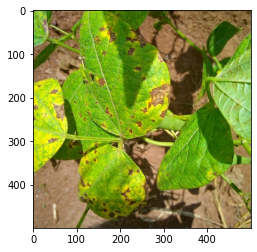

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
Prediction: [[0.00492959 0.9913235  0.003747  ]]


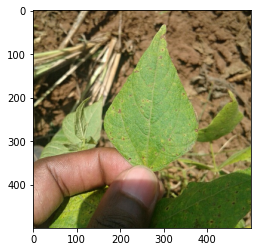

Actual Label: bean_rust
Predicted Label: bean_rust
Prediction: [[0.37623018 0.59472823 0.02904149]]


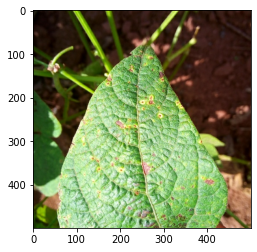

Actual Label: bean_rust
Predicted Label: bean_rust
Prediction: [[0.02870218 0.37666196 0.5946359 ]]


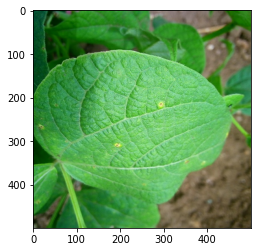

Actual Label: bean_rust
Predicted Label: healthy
Prediction: [[0.00145054 0.00951546 0.98903406]]


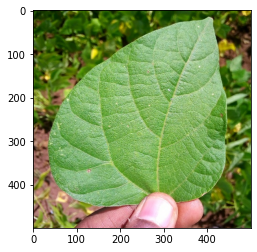

Actual Label: healthy
Predicted Label: healthy
Prediction: [[0.5419802  0.45065826 0.00736148]]


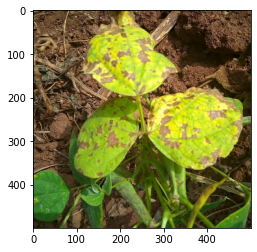

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
Prediction: [[0.0031617  0.98567164 0.01116666]]


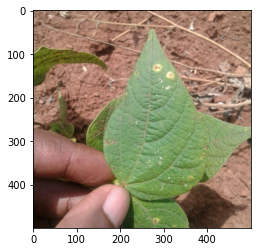

Actual Label: bean_rust
Predicted Label: bean_rust
Prediction: [[9.7966373e-01 2.0207873e-02 1.2835968e-04]]


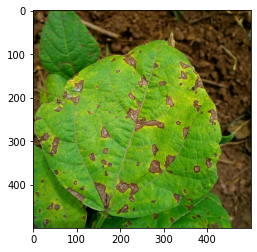

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
Prediction: [[8.7786090e-01 1.2138649e-01 7.5259292e-04]]


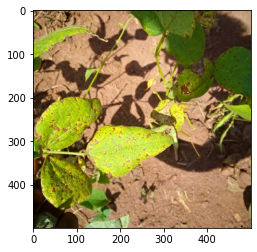

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
Prediction: [[0.05465606 0.840939   0.10440488]]


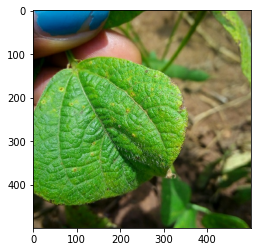

Actual Label: bean_rust
Predicted Label: bean_rust


In [19]:
for test_sample in dataset[1].take(10):
    image, label = test_sample[0], test_sample[1]
    image_scaled, label_arr = scale(test_sample[0], test_sample[1])
    image_scaled = np.expand_dims(image_scaled, axis=0)

    img = tf.keras.preprocessing.image.img_to_array(image)
    predict = model.predict(image_scaled)
    print("Prediction:",predict)

    ### Visalization
    plt.figure()
    plt.imshow(image)
    plt.show()
    print(f"Actual Label: {info.features['label'].names[label.numpy()]}")
    print(f"Predicted Label: {info.features['label'].names[np.argmax(predict)]}")

In [20]:
for f0, f1 in dataset[1].map(scale).batch(200):
    y = np.argmax(f1, axis=1)
    y_predict = np.argmax(model.predict(f0), axis=1)
    print(tf.math.confusion_matrix(labels=y, predictions=y_predict, num_classes=3))

tf.Tensor(
[[40  3  0]
 [ 6 36  1]
 [ 0  6 36]], shape=(3, 3), dtype=int32)


## Saving the model

This is used for the deployment, I think will deploy it tomorrow at Sunday

I will not upload the model because it takes more space :)

In [21]:
model.save('beans_spot.tf')

INFO:tensorflow:Assets written to: beans_spot.tf\assets
INFO:tensorflow:Assets written to: beans_spot.tf\assets


## Thanks